In [1]:
import  tensorflow as tf

In [2]:
# 3D 데이터
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # 3D 데이터 세트 초기화
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # 고르지 않은 분포
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # 타원형
X += 0.28 * np.random.randn(m, 3)  # 노이즈 추가
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # 약간 이동

In [3]:
X.shape

(60, 3)

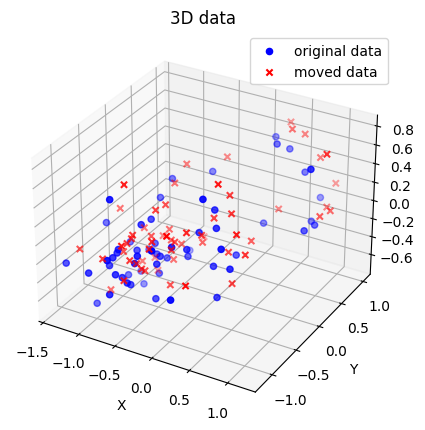

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
# x 원본데이터
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='b', label='original data')
# 이동된 데이터
ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c='r', marker='x',label='moved data')
# 축 레이블
ax.set_title('3D data')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# 범례
ax.legend()
plt.show()


In [5]:
encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])  # 잠재공간이 뉴런이 2개인 2차원 벡터
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])  # 출력 3차원
# 3차원데이터를 2차원 잠재공간 벡터로 만들고 다시 3차원으로 복원
autoencoder = tf.keras.Sequential([encoder, decoder])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='mse')
hist = autoencoder.fit(X_train, X, epochs=500, batch_size=16,verbose=False)
encoding_data = encoder.predict(X_train)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


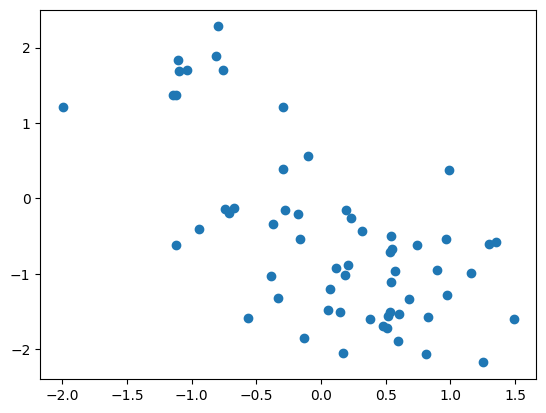

In [6]:
plt.scatter(encoding_data[:,0],encoding_data[:,1])

- 적층 오토 인코더
  - 오토인코더의 변형, 여러층을 쌓아서 더 복잡한 패턴을 학습할 수 있는 구조
  - 여러개의 오토인코더를 층으로 쌓은 형태
  - 각 층은 이전층의 출력값을 입력으로 받아서 다시 학습
  - 특징
    - 오토인코더를 하나씩 학습한후 각층을 독립적으로 미리 학습
  - 단점
    - 층별로 독립적인 학습이 되서서 전체를 학습하는 것보다 효율성이 떨어질수 있다
    
- 심층 오토인코더
  - 여러개의 은닉측을 가진 오토 인코더
  - 적층구조와 거의 동일 , 적층처럼 미리학습즉 따로 하지 않고 모델 전체를 동시에 학습
  - 비선형을 더 잘표현함(더 잘 학습)
  - 단점 : 기울기 소실문제

In [7]:
# 적층 오토 인코더 구현 - fashion mnist
(x_train_full,y_train_full),(x_test,y_test) =  tf.keras.datasets.fashion_mnist.load_data()
x_train_full / 255.0 ; x_test / 255.0
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid \
= train_test_split(x_train_full,y_train_full,stratify=y_train_full, test_size=0.2,random_state=42)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
x_train.shape

(48000, 28, 28)

In [14]:
# 은닉층 3, 출력층 1개  오토 인코더
# Dense층은 벡터를.. 받는다.. 즉. 1차원  28x28 -->
encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(30,activation='relu'),
])
decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(28*28),
    tf.keras.layers.Reshape((28,28))
])
autoencoder = tf.keras.Sequential([encoder,decoder])
autoencoder.compile(loss='mae',optimizer='nadam')
print(x_train.shape, x_valid.shape)
hist = autoencoder.fit(x_train,x_train,epochs=20,validation_data=(x_valid,x_valid))

(48000, 28, 28) (12000, 28, 28)
Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 35.6404 - val_loss: 25.5357
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 25.1420 - val_loss: 24.0905
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 23.9221 - val_loss: 23.5376
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 23.4624 - val_loss: 22.8188
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 22.6255 - val_loss: 22.1022
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 22.0355 - val_loss: 21.8591
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 21.8950 - val_loss: 21.7194
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 21.6947 - val_loss: 21.5209
Epoch 9/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 21.4457 - val_loss: 21.4317
Epoch 10/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 21.4256 - val_loss: 21.3160
Epoch 11/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 21.3

In [17]:
# 모델의 가중치 저장
autoencoder.save_weights('/content/drive/MyDrive/model/autoencoder1.weights.h5')

In [6]:
import tensorflow as tf
encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(30,activation='relu'),
])
decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(28*28),
    tf.keras.layers.Reshape((28,28))
])
autoencoder = tf.keras.Sequential([encoder,decoder])
autoencoder.build(input_shape=(None,28,28)) # 가중치만 로드할때 반드시 build
autoencoder.load_weights('/content/drive/MyDrive/model/autoencoder1.weights.h5')

In [12]:
x_test[[0]].shape

(1, 28, 28)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


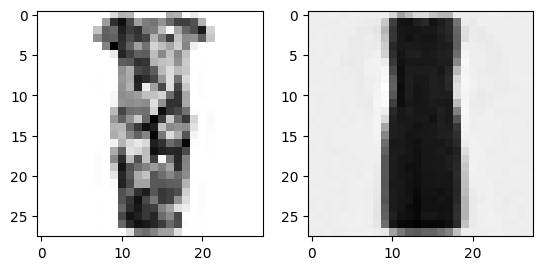

In [19]:
import matplotlib.pyplot as plt
y_pred = autoencoder.predict(x_test[[100]])
plt.subplot(1,2,1)
plt.imshow(x_test[100],cmap='gray_r')
plt.subplot(1,2,2)
plt.imshow(y_pred[0],cmap='gray_r')
plt.show()

- 가중치 묶기
 - 인코더의 가중치 전치를 디코더의 가중치로 사용해서 인코더와 디코더의 가중치를 묶는다
 - 인코더,디코더 같은가중치를 사용하기때문에 학습 파라메터의 수가 줄어든다(절반으로) 인코더가 W 를 사용하면 디코더는 W 전치를 사용한다 즉 추가적인 가중치가 필요 없음
 - 모델의 복잡도 줄어들고 과적합도 줄어든다
 - 두 모델의 일관성을 유지하기때문에 대칭적인 구조를 갖고 안전한 학습이 가능
 - 가중치를 공유하니 학습시 역전파를 한번한 해도 둘다 업데이트

In [99]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)

    def build(self, batch_input_shape):
      #  dense 레이어의 weight를 통해 입력 개수를 추출합니다.
        input_dim = self.dense.weights[0].shape[0]  # weights[0]는 입력 가중치 행렬입니다.
        self.biases = self.add_weight(name="bias",
                                      shape=[input_dim],
                                      initializer="zeros")
        super().build(batch_input_shape)

    def call(self, inputs):
        Z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(Z + self.biases)

In [100]:
tf.random.set_seed(42)  # 추가 코드 - CPU에서 재현성 보장

dense_1 = tf.keras.layers.Dense(100, activation="relu")
dense_2 = tf.keras.layers.Dense(30, activation="relu")

tied_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = x_train.shape[1:]),
    dense_1,
    dense_2
])

tied_decoder = tf.keras.Sequential([
    DenseTranspose(dense_2, activation="relu"),
    DenseTranspose(dense_1),
    tf.keras.layers.Reshape([28, 28])
])

tied_ae = tf.keras.Sequential([tied_encoder, tied_decoder])

# 추가 코드 - 모델을 컴파일하고 훈련합니다.
tied_ae.compile(loss="mse", optimizer="nadam")
history = tied_ae.fit(x_train, x_train, epochs=10,
                      validation_data=(x_valid, x_valid))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 2378.2192 - val_loss: 1149.7755
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 1109.6101 - val_loss: 1023.2117
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 1008.2356 - val_loss: 960.3514
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 953.6130 - val_loss: 932.3707
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 928.4481 - val_loss: 914.9305
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 909.2635 - val_loss: 905.3269
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 896.9303 - val_loss: 895.8279
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 888.5071 - val_loss: 886.8360
Epoch 9/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 880.5114 - val_loss: 881.8408
Epoch 10/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 874.0825 - val_loss: 877.9489


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


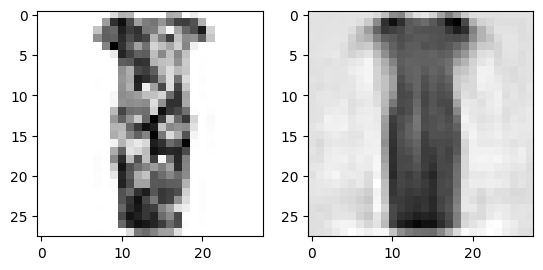

In [101]:
import matplotlib.pyplot as plt
y_pred = tied_ae.predict(x_test[[100]])
plt.subplot(1,2,1)
plt.imshow(x_test[100],cmap='gray_r')
plt.subplot(1,2,2)
plt.imshow(y_pred[0],cmap='gray_r')
plt.show()

- 오토인코더를 하나씩 훈련

In [4]:
# 데이터
import tensorflow as tf
(x_train_full,y_train_full),(x_test,y_test) =  tf.keras.datasets.fashion_mnist.load_data()
x_train_full / 255.0 ; x_test / 255.0
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid \
= train_test_split(x_train_full,y_train_full,stratify=y_train_full, test_size=0.2,random_state=42)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [2]:
# units : 인코더의 출력
# x_train : 오토인코더는 입력 과 출력이 동일
# output_activation 디코더의 출력 활성화 함수
# 데이터의 차원축소, 노이즈 제거, 특징 학습 용도로 다양하게 사용
def train_autoencoder(units, x_train, x_valid, epochs=20, output_activation=None):
  n_inputs = x_train.shape[-1]  # 28*28
  encoder = tf.keras.layers.Dense(units,activation='relu')
  decoder = tf.keras.layers.Dense(n_inputs,activation=output_activation)
  autoencoder = tf.keras.Sequential([encoder,decoder])
  autoencoder.compile(loss='mse',optimizer='nadam')
  autoencoder.fit(x_train,x_train,epochs=epochs,validation_data=(x_valid,x_valid))
  return encoder,decoder,encoder(x_train), encoder(x_valid)

In [3]:
x_train_flat = tf.keras.layers.Flatten()(x_train)
x_valid_flat = tf.keras.layers.Flatten()(x_valid)
dnc1,dec1,x_train_enc1, x_valid_enc1 =  train_autoencoder(100,x_train_flat,x_valid_flat)
dnc2,dec2,x_train_enc2, x_valid_enc2 =  train_autoencoder(30,x_train_enc1,x_valid_enc1)

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 2111.5803 - val_loss: 789.9434
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 731.2364 - val_loss: 645.5283
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 646.5718 - val_loss: 617.7006
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 619.4683 - val_loss: 599.0124
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 608.6313 - val_loss: 587.4789
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 597.6740 - val_loss: 584.9306
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 590.8838 - val_loss: 583.3347
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 590.4537 - val_loss: 578.9304
Epoch 9/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 588.6412 - val_loss: 570.2838
Epoch 10/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 584.7341 - val_loss: 579.2569
Epoch 11/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 584.3180 - val

In [15]:
stacked_1_by_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    dnc1,dnc2,dec2,dec1,
    tf.keras.layers.Reshape((28,28))
    ])

stacked_1_by_1.save('/content/drive/MyDrive/model/stacked_1_by_1.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:102: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


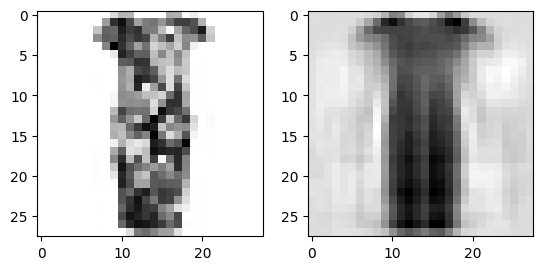

In [5]:
import tensorflow as tf
stacked_1_by_1 = tf.keras.models.load_model('/content/drive/MyDrive/model/stacked_1_by_1.keras')
import matplotlib.pyplot as plt
y_pred = stacked_1_by_1.predict(x_test[[100]])
plt.subplot(1,2,1)
plt.imshow(x_test[100],cmap='gray_r')
plt.subplot(1,2,2)
plt.imshow(y_pred[0],cmap='gray_r')
plt.show()

In [7]:
stacked_1_by_1.compile(loss='mse',optimizer='nadam')
stacked_1_by_1.fit(x_train,x_train,epochs=2,validation_data=(x_valid,x_valid))

Epoch 1/2
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 1088.6488 - val_loss: 1087.9290
Epoch 2/2
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 1077.9121 - val_loss: 1071.3267


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


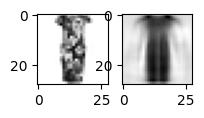

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(2,2))
y_pred = stacked_1_by_1.predict(x_test[[100]])
plt.subplot(1,2,1)
plt.imshow(x_test[100],cmap='gray_r')
plt.subplot(1,2,2)
plt.imshow(y_pred[0],cmap='gray_r')
plt.show()

- 합성곱 오토 인코더
  - 은닉층 3개 출력층 1

In [4]:
# 데이터
import tensorflow as tf
from sklearn.model_selection import train_test_split
(x,y),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train,x_val,y_train,y_val = train_test_split(x,y, stratify=y  ,test_size=0.2,random_state=42)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
# 입력에 사용된 데이터는 28 28 --> 28 28 1
# conv 3차원
# fc(dense) 1차원
# cp cp cp cp
conv_enc = tf.keras.Sequential([
    tf.keras.layers.Reshape((28,28,1)),

    tf.keras.layers.Conv2D(16,3,padding='same',activation='relu'),
    tf.keras.layers.MaxPool2D(),  # 14 14 16

    tf.keras.layers.Conv2D(32,3,padding='same',activation='relu'),
    tf.keras.layers.MaxPool2D(), # 7 7 32

    tf.keras.layers.Conv2D(64,3,padding='same',activation='relu'),
    tf.keras.layers.MaxPool2D(), # 3 3 64

    tf.keras.layers.Conv2D(30,3,padding='same',activation='relu'),
    tf.keras.layers.GlobalMaxPool2D() # 1 1 30
])
conv_dec = tf.keras.Sequential([
    tf.keras.layers.Dense(3*3*64,activation='relu'),
    tf.keras.layers.Reshape((3,3,64)),
    tf.keras.layers.Conv2DTranspose(32,3,strides=2,activation='relu'),
    tf.keras.layers.Conv2DTranspose(16,3,strides=2,padding='same', activation='relu'),
    # 마지막 출력을 2차원
    tf.keras.layers.Conv2DTranspose(1,3,strides=2,padding='same'),
    tf.keras.layers.Reshape((28,28))
])
conv_ae = tf.keras.Sequential([conv_enc,conv_dec])
conv_ae.compile(loss='mse',optimizer='nadam')
history = conv_ae.fit(x_train,x_train,epochs=1,validation_data=(x_val,x_val))
conv_ae.save('/content/drive/MyDrive/model/conv_ae.keras')

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 2609.6208 - val_loss: 1126.0941


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step


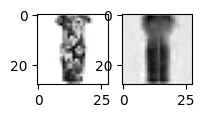

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
conv_ae = tf.keras.models.load_model('/content/drive/MyDrive/model/conv_ae.keras')
import matplotlib.pyplot as plt
plt.figure(figsize=(2,2))
y_pred = conv_ae.predict(x_test[[100]])
plt.subplot(1,2,1)
plt.imshow(x_test[100],cmap='gray_r')
plt.subplot(1,2,2)
plt.imshow(y_pred[0],cmap='gray_r')
plt.show()

비지도 학습
   - 오토인코더를 이용해서 정상적인 데이터를 인코딩디코딩 모델 을 만들어서
   - 임의의 데이터를 인코딩 디코이했을때 재구성의 오류가 높게 나타나면 비정상 데이터라고 판단

In [1]:
!unzip '/content/ECG_이상치탐지.zip'

Archive:  /content/ECG_이상치탐지.zip
  inflating: ecg.csv                 


In [2]:
import pandas as pd
df = pd.read_csv('/content/ecg.csv',header=None)
df  # 마지막이 라벨 0정상 1비정상

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,0.608558,-0.335651,-0.990948,-1.784153,-2.626145,-2.957065,-2.931897,-2.664816,-2.090137,-1.461841,...,1.757705,2.291923,2.704595,2.451519,2.017396,1.704358,1.688542,1.629593,1.342651,0.0
4994,-2.060402,-2.860116,-3.405074,-3.748719,-3.513561,-3.006545,-2.234850,-1.593270,-1.075279,-0.976047,...,1.388947,2.079675,2.433375,2.159484,1.819747,1.534767,1.696818,1.483832,1.047612,0.0
4995,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.638360,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.176790,-4.009720,-2.874136,-2.008369,-1.808334,0.0
4996,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.492560,-2.695270,-1.849691,-1.374321,...,1.258419,1.907530,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,0.0


In [3]:
# 심장박동수
# 정상, 비정상
normal_ecg = df[df.iloc[:,-1] == 0]
abnormal_ecg = df[df.iloc[:,-1] == 1]

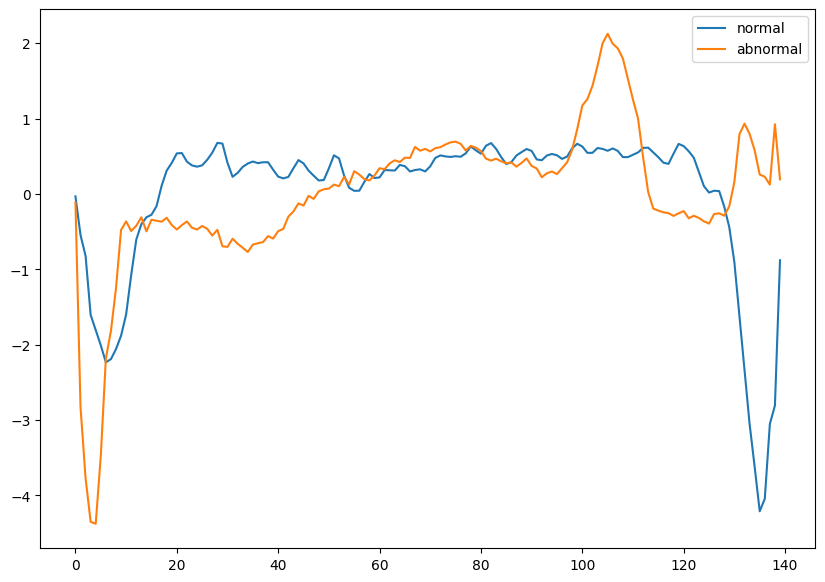

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.plot(normal_ecg.iloc[0,:-1],label='normal')
plt.plot(abnormal_ecg.iloc[0,:-1],label='abnormal')
plt.legend()

In [ ]:
# 데이터로드
# 정상데이터를 필터링(라벨이 0)
# 데이터 정규화
# autoencoder 모델 정의(일반적방법, 가중치 맞추는방법, 단계적 인코딩)
# 모델 훈련
# 이상탐지(정상데이터와 비정상데이터를 평가 , 재구성 오류 계산->임계치도 정해 )

In [4]:
# 데이터 정규화
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
data = scaler.fit_transform(normal_ecg.iloc[:,:-1])
target = normal_ecg.iloc[:,-1]
x,x_test,y,y_test =  train_test_split(data,target, test_size=0.1,random_state=42,shuffle=False)
x_train,x_val, y_train, y_val = train_test_split(x,y, test_size=0.1,random_state=42,shuffle=False)

In [8]:
import tensorflow as tf
encoded = tf.keras.Sequential([
    tf.keras.layers.Input(shape=x_train.shape[1:]),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(8,activation='relu'),
])
decoded = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(8,)),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(x_train.shape[-1])
])
autoencoder = tf.keras.Sequential([encoded,decoded])
autoencoder.compile(loss='mse',optimizer='adam')
autoencoder.fit(x_train,x_train,epochs=20,batch_size=512, validation_data=(x_val,x_val),shuffle=True)
autoencoder.save('/content/drive/MyDrive/model/autoencoder_ecs.keras')

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - loss: 0.9946 - val_loss: 0.6620
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.9864 - val_loss: 0.6529
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9747 - val_loss: 0.6413
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9696 - val_loss: 0.6247
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9576 - val_loss: 0.6038
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9088 - val_loss: 0.5812
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8825 - val_loss: 0.5593
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8534 - val_loss: 0.5371
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8008 - val_loss: 0.5141
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7847 - val_loss: 0.4920
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7558 - val_loss: 0.4720
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7381 - val_loss: 0.4523
Epoch 13/

In [6]:
import tensorflow as tf
autoencoder = tf.keras.models.load_model('/content/drive/MyDrive/model/autoencoder_ecs.keras')

In [9]:
x_train.shape, normal_ecg.shape

((1683, 140), (2079, 141))

In [14]:
# 정상데이터와 비정상데이터의 대한 재구성 오류
normal_reconstruction = autoencoder.predict(normal_ecg.iloc[:,:-1])
abnormal_reconstruction = autoencoder.predict(abnormal_ecg.iloc[:,:-1])
# 재구성 오류 계산
import numpy as np

normal_loss =  np.mean(np.power(normal_ecg.iloc[:,:-1] - normal_reconstruction,2),axis=1)
abnormal_loss =  np.mean(np.power(abnormal_ecg.iloc[:,:-1] - abnormal_reconstruction,2),axis=1)
normal_loss.shape, abnormal_loss.shape

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


((2079,), (2919,))

In [18]:
# 임계값 설정
threshold = np.percentile(normal_loss,95)  # 상위 5%를 이상치로 판단하도록 하는 임계치
# 정상데이터중에 발견된 이상치 수
normal_danger = normal_loss > threshold
print(f"정상데이터중에 이상치 수 : {np.sum(normal_danger)}")
# 비정상 데이터중에 발견된 이상치 수
abnormal_danger = abnormal_loss > threshold
print(f"비정상데이터중에 이상치 수 : {np.sum(abnormal_danger)}")

정상데이터중에 이상치 수 : 104
비정상데이터중에 이상치 수 : 65


- 정상데이터 중에서 104개가 이상치로 탐지
- 모델이 정상데이터를 잘 처리 못했다, 또는 임계치가 너무 낮다
- False Positive

- 비정상중에 65개는 이 모델이 비정상데이터는 어느정도 잘 성공했다는 의미
-True Positive

시각화

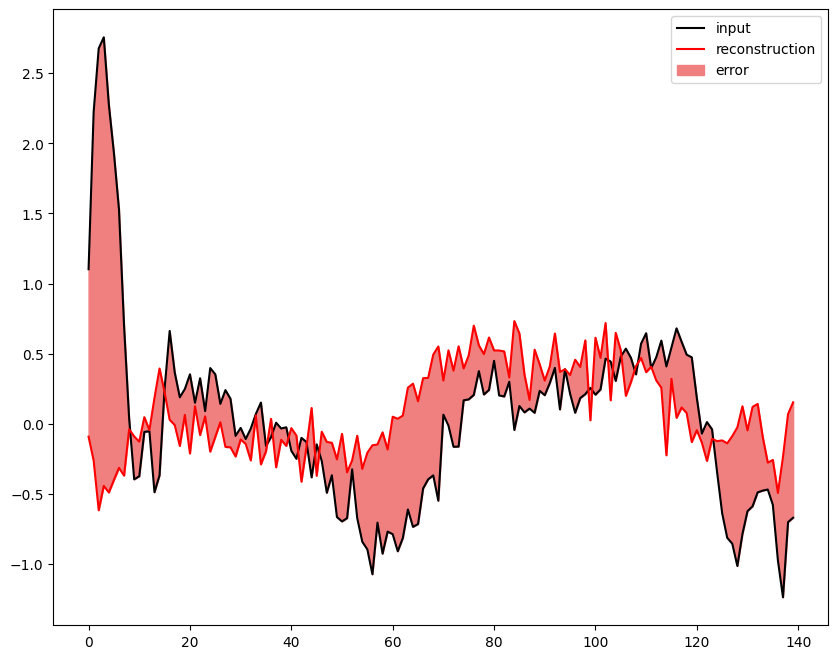

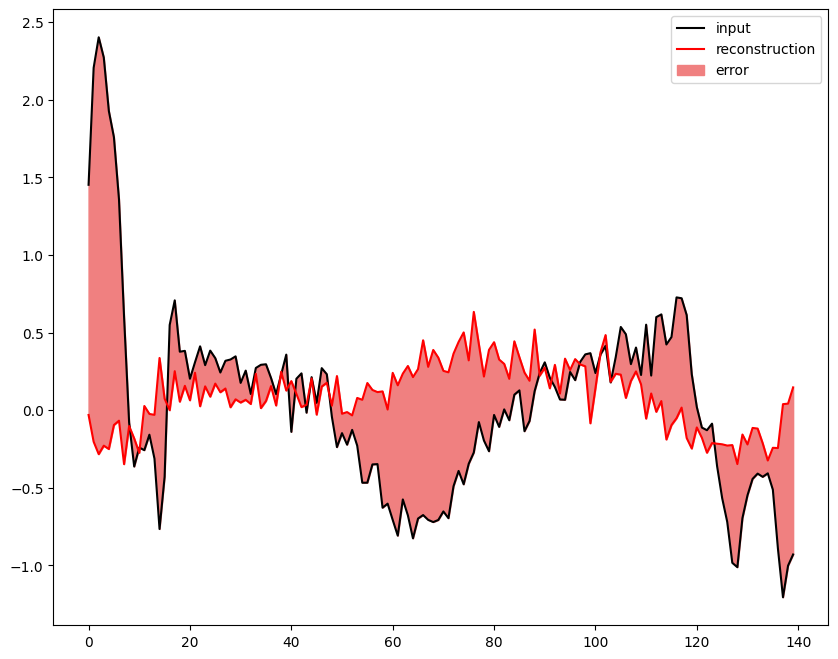

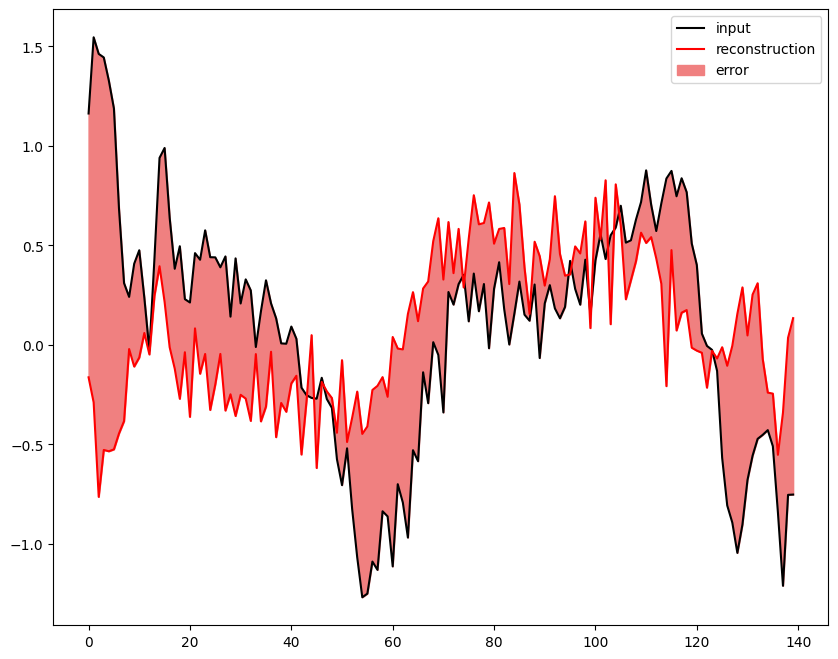

In [39]:
import matplotlib.pyplot as plt

for i in range(3):
  plt.figure(figsize=(10,8))
  plt.plot(x_test[i] ,'black', label='input')
  plt.plot(normal_reconstruction[i],'r',label='reconstruction')
  plt.fill_between(range(x_test.shape[1]),x_test[i],normal_reconstruction[i],color='lightcoral',label='error')
  plt.legend()
  plt.show()



- abnormal data show

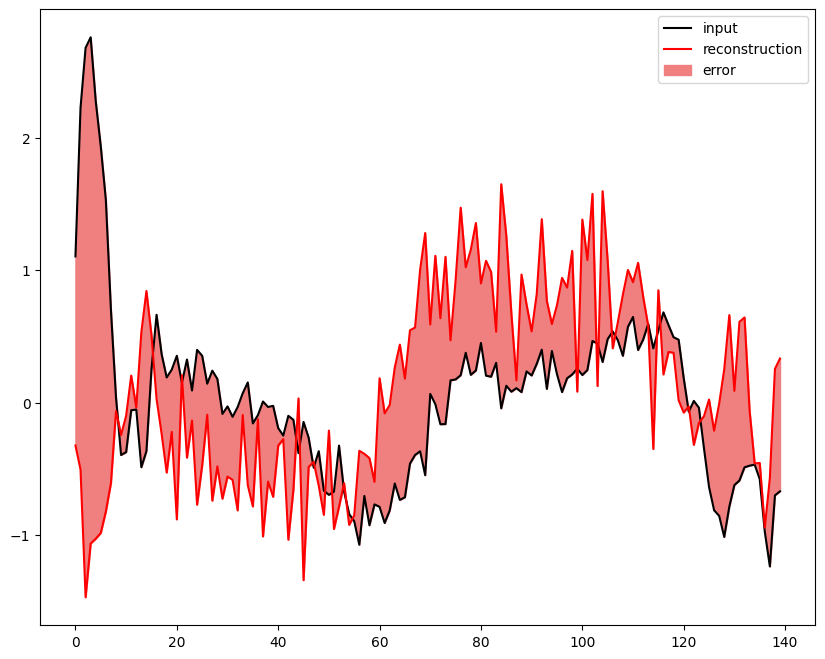

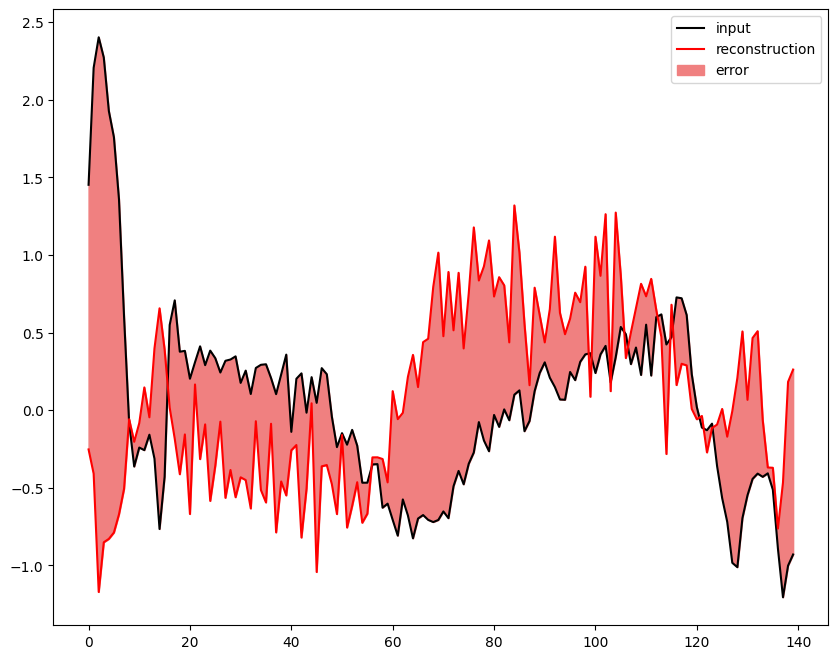

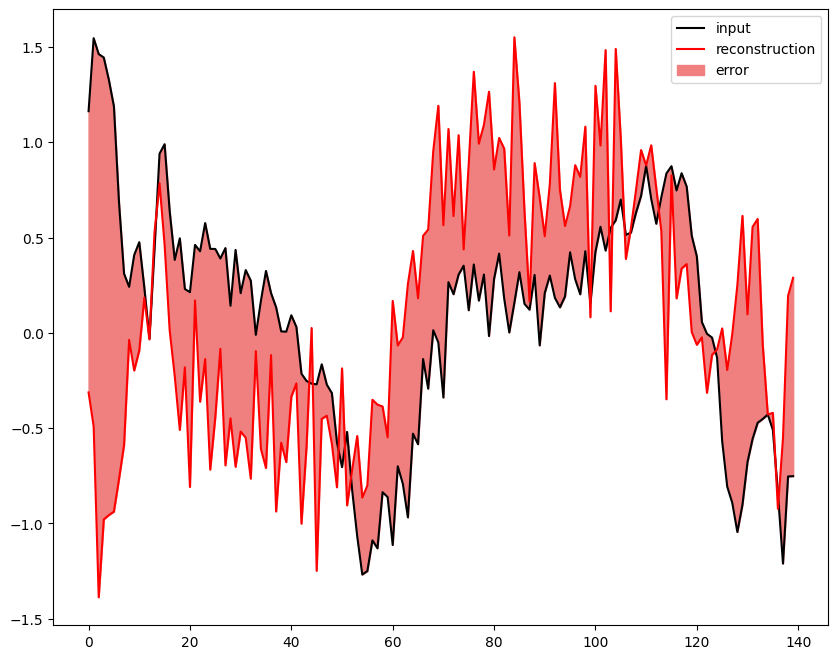

In [40]:
import matplotlib.pyplot as plt

for i in range(3):
  plt.figure(figsize=(10,8))
  plt.plot(x_test[i] ,'black', label='input')
  plt.plot(abnormal_reconstruction[i],'r',label='reconstruction')
  plt.fill_between(range(x_test.shape[1]),x_test[i],abnormal_reconstruction[i],color='lightcoral',label='error')
  plt.legend()
  plt.show()


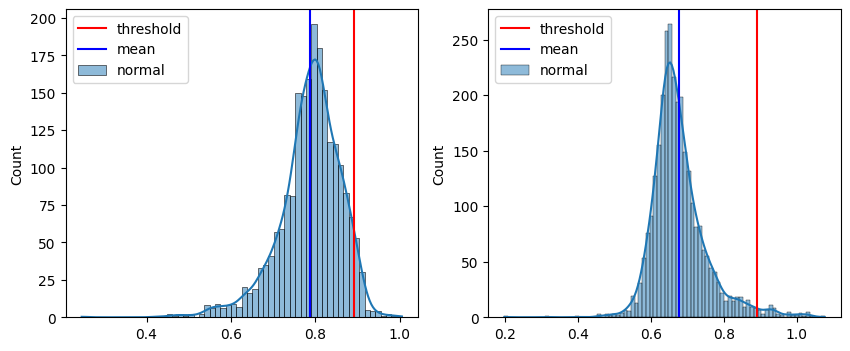

In [53]:
import seaborn as sns
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.histplot(normal_loss,label='normal',kde=True)
plt.axvline(threshold,color='r',label='threshold')
plt.axvline(np.mean(normal_loss),color='b',label='mean')
plt.legend()

plt.subplot(1,2,2)
sns.histplot(abnormal_loss,label='normal',kde=True)
plt.axvline(threshold,color='r',label='threshold')
plt.axvline(np.mean(abnormal_loss),color='b',label='mean')
plt.legend()

plt.show()


In [54]:
# confusion metrix

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


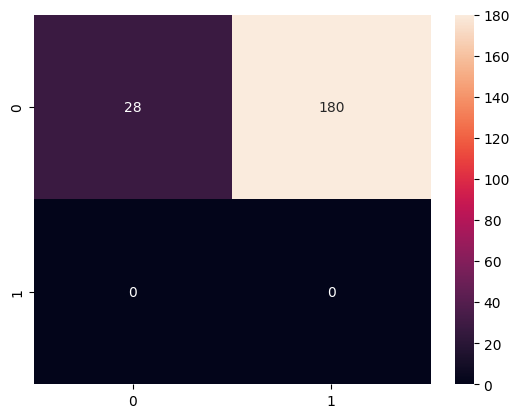

              precision    recall  f1-score   support

         0.0       1.00      0.13      0.24       208
         1.0       0.00      0.00      0.00         0

    accuracy                           0.13       208
   macro avg       0.50      0.07      0.12       208
weighted avg       1.00      0.13      0.24       208



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [76]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

x_test_reconstruct =  autoencoder.predict(x_test)
x_test_loss = np.mean(np.power(x_test - x_test_reconstruct,2),axis=1)
y_pred = tf.math.less(x_test_loss,threshold)
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d')
plt.show()

print(classification_report(y_test,y_pred))
